<a href="https://colab.research.google.com/github/Rohitd922/ECEN-743-RL/blob/main/DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gymnasium as gym

import torch.optim as optim
from collections import deque
import random
import torch
import torch.nn as nn

In [3]:
env = gym.make("CartPole-v1")

In [4]:
state_size = env.observation_space.shape[0]
n_actions = env.action_space.n

In [5]:
env.reset()[0]

array([-0.01567289,  0.00228103, -0.00392526, -0.0289703 ], dtype=float32)

In [6]:
### define a q net that takes in value of the state and give qvalues for each actions

class Q_net(nn.Module):
  def __init__(self, state_size, actions):
    super().__init__()

    self.seq = nn.Sequential(
        nn.Linear(state_size, 64),
        nn.ReLU(),
        nn.Linear(64 , 64),
        nn.ReLU(),
        nn.Linear(64, actions)
    )

  def forward(self, state):
    return self.seq(state)


In [7]:
class replay_buffer():
  def __init__(self, maxlen):

    self.buffer = deque(maxlen=maxlen)    #### this is like a list of list where older experiences are forgotten

  def add(self, experience):
    self.buffer.append(experience)        #### add a new list to the deque

  def sample(self, batch_size):
    return random.sample(self.buffer, len(self.buffer))
  def __len__(self):
    return len(self.buffer)

In [43]:
### arguments for the reinforcement learning
max_steps = 100
num_episodes = 100
alpha = 0.99
learning_rate = 10e-3
buffer_size = 10000

batch_size = 256
target_update_freq = 20

epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.9

In [44]:
### initialize the network
q_net = Q_net(state_size, n_actions)
q_target = Q_net(state_size, n_actions)
q_target.load_state_dict(q_net.state_dict())
q_target.eval()
buffer = replay_buffer(buffer_size)

In [45]:
optimizer = optim.Adam(q_net.parameters(), lr=learning_rate)
criteria = nn.MSELoss()

In [46]:
episode_rewards = []
for i in range(num_episodes):
  state = env.reset()[0]
  total_reward = 0

  for j in range(max_steps):

    if random.random() < epsilon:
      action = env.action_space.sample()
    else:
      with torch.no_grad():
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        action = torch.argmax(q_net(state_tensor)).item()

    next_state, reward, done, trunc, _ = env.step(action)

    total_reward += reward

    buffer.add((state, action, reward, next_state, done))

    state = next_state

    if len(buffer) >= batch_size:
      batch = buffer.sample(batch_size)

      states, actions, rewards, next_states, dones = zip(*batch)
      states = torch.FloatTensor(np.array(states))
      actions = torch.LongTensor(np.array(actions)).unsqueeze(1)
      rewards = torch.FloatTensor(np.array(rewards)).unsqueeze(1)
      next_states = torch.FloatTensor(np.array(next_states))
      dones = torch.FloatTensor(np.array(dones)).unsqueeze(1)

      ### q_values has the diff to update the weights and it has to be same as target
      q_values = q_net(states).gather(1, actions)


      with torch.no_grad():
        next_q_values = q_target(next_states).max(1)[0].unsqueeze(1)
        target_q_values = rewards + (1 - dones) * alpha * next_q_values

      loss = criteria(q_values, target_q_values)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


    if j % target_update_freq == 0:
      q_target.load_state_dict(q_net.state_dict())

    if done or trunc:
      #print(f"Episode {i}, Total Reward {total_reward}")
      break
  episode_rewards.append(total_reward)

  epsilon = max(epsilon * epsilon_decay, epsilon_min)
  if i % 10 == 0:
    print(f"episode: {i}, total_rewards: {total_reward}, epsilon: {epsilon}")


episode: 0, total_rewards: 11.0, epsilon: 0.9
episode: 10, total_rewards: 14.0, epsilon: 0.31381059609000017
episode: 20, total_rewards: 63.0, epsilon: 0.10941898913151243
episode: 30, total_rewards: 100.0, epsilon: 0.03815204244769462
episode: 40, total_rewards: 100.0, epsilon: 0.013302794647291147
episode: 50, total_rewards: 100.0, epsilon: 0.01
episode: 60, total_rewards: 100.0, epsilon: 0.01
episode: 70, total_rewards: 100.0, epsilon: 0.01
episode: 80, total_rewards: 100.0, epsilon: 0.01
episode: 90, total_rewards: 100.0, epsilon: 0.01


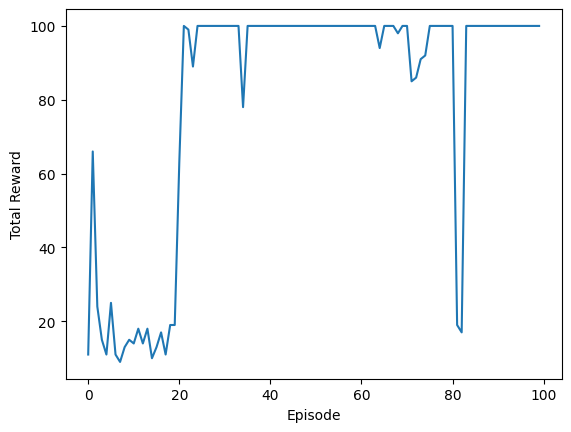

In [47]:
### plot the training error
plt.plot(episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.show()